# Autoencoder and VAE

Sources:
- https://medium.com/@sofeikov/implementing-variational-autoencoders-from-scratch-533782d8eb95
- https://medium.com/@rekalantar/variational-auto-encoder-vae-pytorch-tutorial-dce2d2fe0f5f
- https://avandekleut.github.io/vae/
- https://shashank7-iitd.medium.com/understanding-vector-quantized-variational-autoencoders-vq-vae-323d710a888a
- https://jaan.io/what-is-variational-autoencoder-vae-tutorial/


## Autoencoder

In [29]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid

# create a transofrm to apply to each datapoint
transform = transforms.Compose(
    [transforms.ToTensor(),
    # transforms.Normalize((0.5,), (0.5,)), # Normalize from [0, 1] to [-1, 1]
    ]
)

# download the MNIST datasets
path = '~/datasets'
train_dataset = MNIST(path, transform=transform, download=True)
test_dataset  = MNIST(path, train=False, transform=transform, download=True)

# create train and test dataloaders
batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

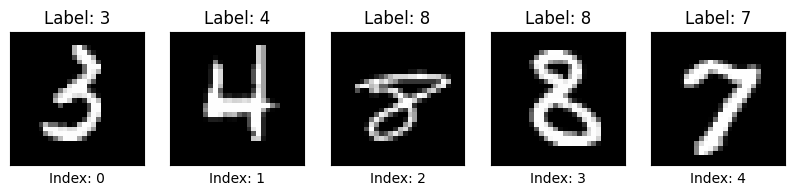

torch.Size([1, 28, 28])


In [14]:
def show_images(images, labels):
    """
    Display a set of images and their labels using matplotlib.
    The first column of `images` should contain the image indices,
    and the second column should contain the flattened image pixels
    reshaped into 28x28 arrays.
    """
    # Extract the image indices and reshaped pixels
    pixels = images.reshape(-1, 28, 28)

    # Create a figure with subplots for each image
    fig, axs = plt.subplots(
        ncols=len(images), nrows=1, figsize=(10, 3 * len(images))
    )

    # Loop over the images and display them with their labels
    for i in range(len(images)):
        # Display the image and its label
        axs[i].imshow(pixels[i], cmap="gray")
        axs[i].set_title("Label: {}".format(labels[i]))

        # Remove the tick marks and axis labels
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i].set_xlabel("Index: {}".format(i))

    # Adjust the spacing between subplots
    fig.subplots_adjust(hspace=0.5)

    # Show the figure
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)
show_images(images[:5], labels[:5])
print(images[0].shape)

In [34]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.lin1 = nn.Linear(28*28, 256)
        self.lin2 = nn.Linear(256, latent_dim)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.lin1(x))
        return self.lin2(x)

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.lin1 = nn.Linear(latent_dim, 256)
        self.lin2 = nn.Linear(256, 28*28)

    def forward(self, z):
        z = F.relu(self.lin1(z))
        z = torch.sigmoid(self.lin2(z))
        return z.reshape(-1, 1, 28, 28)


class AutoEncoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return z, x_hat

In [35]:
# Training
# Do not need labels since unsupervised learning
import torch.optim as optim

learning_rate = 1e-3
num_epochs = 5

# Create the autoencoder model and optimizer
latent_dim = 2
model = AutoEncoder(latent_dim)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define the loss function
criterion = nn.MSELoss()

# Set the device to GPU if available, otherwise use CPU
model.to(device)

# Training loop
for epoch in range(num_epochs):
    total_loss = 0.0
    for batch_idx, (x, _) in enumerate(train_loader):
        # Get a batch of training data and move it to the device
        x = x.to(device)
        optimizer.zero_grad()

        # Forward pass
        z, x_hat = model(x)

        # Compute the loss and perform backpropagation
        loss = criterion(x_hat, x)
        loss.backward()
        optimizer.step()

        # Update the running loss
        total_loss += loss.item() * x.size(0)

    # Print the epoch loss
    epoch_loss = total_loss / len(train_loader.dataset)
    print(
        "Epoch {}/{}: loss={:.4f}".format(epoch + 1, num_epochs, epoch_loss)
    )

Epoch 1/5: loss=0.0581
Epoch 2/5: loss=0.0488
Epoch 3/5: loss=0.0471
Epoch 4/5: loss=0.0461
Epoch 5/5: loss=0.0453


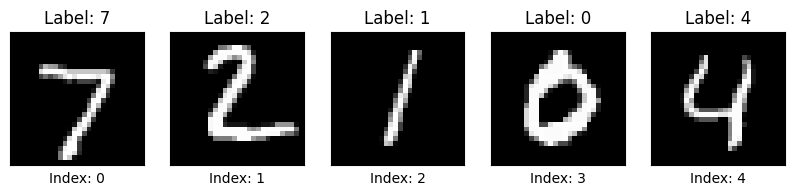

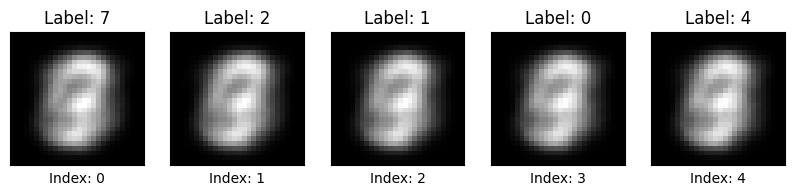

In [50]:
def show_example_reconstruction():
    testiter = iter(test_loader)
    images, labels = next(testiter)
    show_images(images[:5], labels[:5])
    _, x_hat = model(images[:5])
    show_images(x_hat.detach(), labels[:5])

show_example_reconstruction()

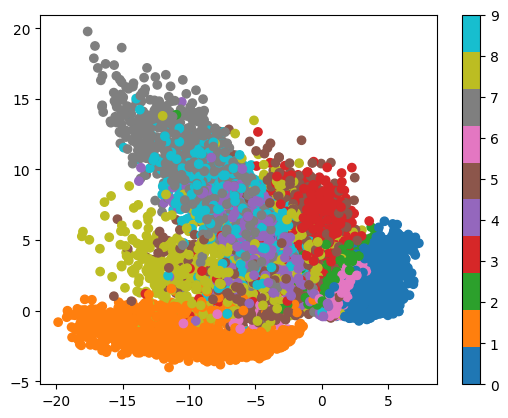

In [37]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

plot_latent(model, train_loader)

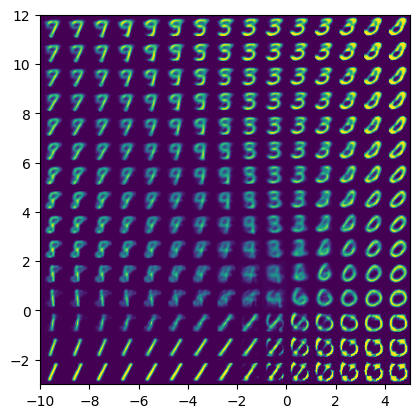

In [39]:
def plot_reconstructed(autoencoder, r0=(-10, 5), r1=(-3, 12), n=15):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

plot_reconstructed(model)

## Variational Autoencoder

- Autoencoders only have a constraint that the latent space needs to be decodable - it can become disjointed and difficult to sample
- Variational AE map inputs to probability distributions, which can then be sampled to generate latent vectors
- Use the standard normal distribution N(0,1) to add an additonal error through KL-divergence - the network learns a latent distribution that is similar to N(0,1)
- It is differentiable by taking a sample of N(0,1), then multiplying the learned variance and adding the mean
- The decoding of this type or latent vector is much more robust, and therefore better for generative applications

In [46]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.lin1 = nn.Linear(28*28, 256)
        self.lin_mu = nn.Linear(256, latent_dim)
        self.lin_sig = nn.Linear(256, latent_dim)

        self.N = torch.distributions.Normal(0,1)
        self.kl = 0

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.lin1(x))
        mu = self.lin_mu(x)
        sig = torch.exp(self.lin_sig(x))
        z = mu + sig * self.N.sample(mu.shape)
        self.kl = (sig**2 + mu**2 - torch.log(sig) - 1/2).sum()
        return z

class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return z, x_hat

In [51]:
# Training
# Do not need labels since unsupervised learning
learning_rate = 1e-3
num_epochs = 5

# Create the autoencoder model and optimizer
latent_dim = 2
model = VariationalAutoencoder(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define the loss function
criterion = nn.BCELoss(reduction="sum")

# Training loop
for epoch in range(num_epochs):
    total_loss = 0.0
    for batch_idx, (x, _) in enumerate(train_loader):
        # Get a batch of training data and move it to the device
        x = x.to(device)
        optimizer.zero_grad()

        # Forward pass
        z, x_hat = model(x)

        # Compute the loss and perform backpropagation
        loss = (criterion(x_hat, x) + model.encoder.kl)
        loss.backward()
        optimizer.step()

        # Update the running loss
        total_loss += loss.item() * x.size(0)

    # Print the epoch loss
    epoch_loss = total_loss / len(train_loader.dataset)
    print(
        "Epoch {}/{}: loss={:.4f}".format(epoch + 1, num_epochs, epoch_loss)
    )

Epoch 1/5: loss=19604.2282
Epoch 2/5: loss=17034.5225
Epoch 3/5: loss=16563.1997
Epoch 4/5: loss=16293.3699
Epoch 5/5: loss=16095.7640


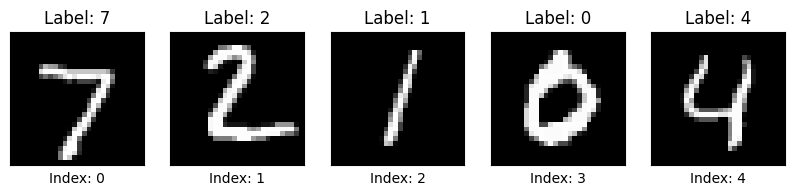

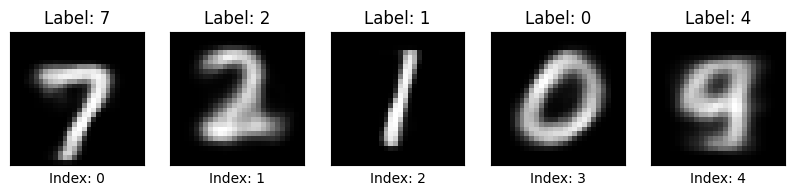

In [52]:
show_example_reconstruction()

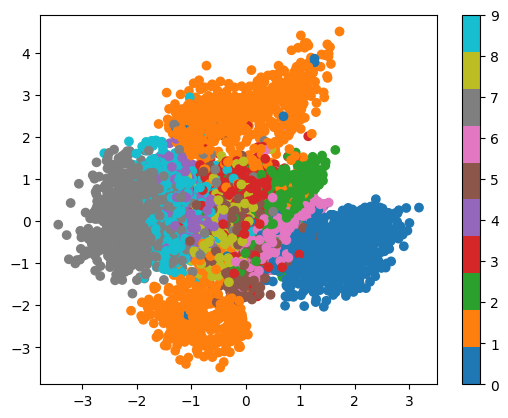

In [54]:
plot_latent(model, train_loader)

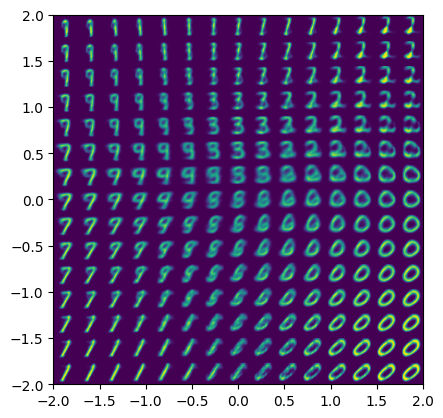

In [59]:
plot_reconstructed(model, r0=(-2, 2), r1=(-2, 2))

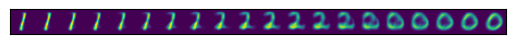

In [64]:
def interpolate(autoencoder, x_1, x_2, n=12):
    z_1 = autoencoder.encoder(x_1)
    z_2 = autoencoder.encoder(x_2)
    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])
    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.to('cpu').detach().numpy()

    w = 28
    img = np.zeros((w, n*w))
    for i, x_hat in enumerate(interpolate_list):
        img[:, i*w:(i+1)*w] = x_hat.reshape(28, 28)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

x, y = next(iter(test_loader))
x_1 = x[y == 1][1].to(device) # find a 1
x_2 = x[y == 0][1].to(device) # find a 0
interpolate(model, x_1, x_2, n=20)

In [65]:
from PIL import Image

def interpolate_gif(autoencoder, filename, x_1, x_2, n=100):
    z_1 = autoencoder.encoder(x_1)
    z_2 = autoencoder.encoder(x_2)

    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])

    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.to('cpu').detach().numpy()*255

    images_list = [Image.fromarray(img.reshape(28, 28)).resize((256, 256)) for img in interpolate_list]
    images_list = images_list + images_list[::-1] # loop back beginning

    images_list[0].save(
        f'{filename}.gif',
        save_all=True,
        append_images=images_list[1:],
        loop=1)
interpolate_gif(model, "vae", x_1, x_2)